Delete all variables in the current environment (if you have already run some cells) - clean state

In [119]:
%reset

Import all necessary packages

In [120]:
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import shutil
from datetime import datetime
from dateutil import parser

Replace with the path to the root folder of the project

In [121]:
rootdir_path = '/home/andreistoica12/research-internship'

Replace with the path to the folder where we store the dataset

In [122]:
data_path = '/home/andreistoica12/research-internship/data/covaxxy-csv'

Create 2 subfolders to store important files and graphs, respectively. If they already existed (from previous runnings of the project), delete the folders and their contents and create empty folders to store the current files and graphs, relevant to the current state of the project.

In [123]:
files_path = os.path.join(rootdir_path, 'files')
if os.path.exists(files_path):
   shutil.rmtree(files_path, ignore_errors=False, onerror=None)
os.makedirs(files_path)

graphs_path = os.path.join(rootdir_path, 'graphs')
if os.path.exists(graphs_path):
   shutil.rmtree(graphs_path, ignore_errors=False, onerror=None)
os.makedirs(graphs_path)

In [124]:
os.listdir(data_path)

['tweet_ids--2021-03-02.csv',
 'tweet_ids--2021-03-03.csv',
 'tweet_ids--2021-03-05.csv',
 'tweet_ids--2021-03-04.csv',
 'tweet_ids--2021-03-01.csv']

In [125]:
first_batch_path = os.path.join(data_path, os.listdir(data_path)[4])

In [126]:
first_batch = pd.read_csv(first_batch_path, index_col=0)

In [127]:
first_batch

,created_at,tweet_id,author_id,text,followers_count,following_count
0,2021-03-01T00:01:56.000Z,1366176845561962503,14914686,@UK_Centrist @_PhB @RolandBakerIII @RicardLope...,639,349
1,2021-03-01T00:01:57.000Z,1366176846895738883,2402490445,"RT @THE_Russell: Berijiklian: ""There may be a ...",1215,4924
2,2021-03-01T00:01:57.000Z,1366176847822811145,56147198,RT @YvetteCooperMP: Cases of the Brazil varian...,1304,589
3,2021-03-01T00:01:57.000Z,1366176848225464323,1252300308165857280,RT @OfficialKat: Cannot wait for the vaccine. ...,154,267
4,2021-03-01T00:01:57.000Z,1366176848284057600,190474968,New vaccination appointments available tomorro...,1410,1602
...,...,...,...,...,...,...
606463,2021-03-01T03:27:26.000Z,1366228560290009091,1199985222432878592,"@goppiaziz At least, vaccinated person can get...",66,119
606464,2021-03-01T03:27:26.000Z,1366228561250701317,172453839,RT @POTUS: The more people that get vaccinated...,798,4999
606465,2021-03-01T03:27:26.000Z,1366228561389051905,47777004,RT @OfficialKat: Cannot wait for the vaccine. ...,2269,1650
606466,2021-03-01T03:27:27.000Z,1366228561724645376,1422286680,@Haugmoen It seems to be easier now that I hav...,290,293


In [128]:
hours = []
for time in first_batch.loc[:,"created_at"]:
    hour = parser.parse(time).hour
    hours.append(hour)

In [129]:
first_batch.insert(1, "hour", hours, True)

In [130]:
first_batch

,created_at,hour,tweet_id,author_id,text,followers_count,following_count
0,2021-03-01T00:01:56.000Z,0,1366176845561962503,14914686,@UK_Centrist @_PhB @RolandBakerIII @RicardLope...,639,349
1,2021-03-01T00:01:57.000Z,0,1366176846895738883,2402490445,"RT @THE_Russell: Berijiklian: ""There may be a ...",1215,4924
2,2021-03-01T00:01:57.000Z,0,1366176847822811145,56147198,RT @YvetteCooperMP: Cases of the Brazil varian...,1304,589
3,2021-03-01T00:01:57.000Z,0,1366176848225464323,1252300308165857280,RT @OfficialKat: Cannot wait for the vaccine. ...,154,267
4,2021-03-01T00:01:57.000Z,0,1366176848284057600,190474968,New vaccination appointments available tomorro...,1410,1602
...,...,...,...,...,...,...,...
606463,2021-03-01T03:27:26.000Z,3,1366228560290009091,1199985222432878592,"@goppiaziz At least, vaccinated person can get...",66,119
606464,2021-03-01T03:27:26.000Z,3,1366228561250701317,172453839,RT @POTUS: The more people that get vaccinated...,798,4999
606465,2021-03-01T03:27:26.000Z,3,1366228561389051905,47777004,RT @OfficialKat: Cannot wait for the vaccine. ...,2269,1650
606466,2021-03-01T03:27:27.000Z,3,1366228561724645376,1422286680,@Haugmoen It seems to be easier now that I hav...,290,293


In [131]:
hour_column_ascending = first_batch.loc[:,"hour"].sort_values(ascending=True)

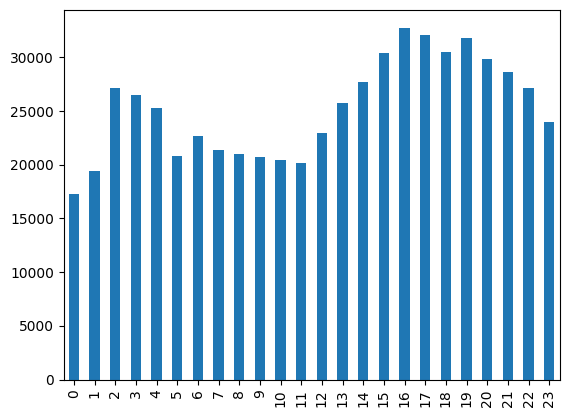

In [132]:
axes = hour_column_ascending.value_counts()[hour_column_ascending.unique()].plot(kind='bar')

In [133]:
axes.figure.savefig(graphs_path + "/first_batch_distribution.png")